In [35]:
import pandas as pd
from sklearn import datasets
import numpy as np
df = pd.read_csv('/Users/Aviva/Documents/GitHub/PHBS_TQFML/dataset/bank.csv', sep=';')

In [36]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


#  Step1: Data prepocessing

In [37]:
#Encoding class labels
import numpy as np
y_mapping = {label: idx for idx, label in enumerate(np.unique(df['y']))}
y_mapping
df['y']=df['y'].map(y_mapping)

default_mapping = {label: idx for idx, label in enumerate(np.unique(df['default']))}
default_mapping
df['default']=df['default'].map(default_mapping)

housing_mapping = {label: idx for idx, label in enumerate(np.unique(df['housing']))}
housing_mapping
df['housing']=df['housing'].map(housing_mapping)

loan_mapping = {label: idx for idx, label in enumerate(np.unique(df['loan']))}
loan_mapping
df['loan']=df['loan'].map(loan_mapping)


month_mapping = {'jan': 1,
                 'feb': 2,
                 'mar': 3,
                 'apr': 4,
                 'may': 5,
                 'jun': 6,
                 'jul': 7,
                 'aug': 8,
                 'sep': 9,
                 'oct': 10,
                 'nov': 11,
                 'dec': 12}
df['month'] = df['month'].map(month_mapping)

#Performing one-hot encoding on norminal features
df_with_dummies = pd.get_dummies(df[['age','job', 'marital', 'education','default','balance','housing','loan',
                   'contact','day','month','duration','campaign','pdays','previous',
                   'poutcome','y']])

In [38]:
#identifying missing values
df_with_dummies.isnull().sum()

age                    0
default                0
balance                0
housing                0
loan                   0
day                    0
month                  0
duration               0
campaign               0
pdays                  0
previous               0
y                      0
job_admin.             0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_divorced       0
marital_married        0
marital_single         0
education_primary      0
education_secondary    0
education_tertiary     0
education_unknown      0
contact_cellular       0
contact_telephone      0
contact_unknown        0
poutcome_failure       0
poutcome_other         0
poutcome_success       0
poutcome_unknown       0
dtype: int64

In [39]:
df_with_dummies.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,10,79,1,-1,...,0,0,0,1,0,0,0,0,0,1
1,33,0,4789,1,1,11,5,220,1,339,...,1,0,0,1,0,0,1,0,0,0
2,35,0,1350,1,0,16,4,185,1,330,...,0,1,0,1,0,0,1,0,0,0
3,30,0,1476,1,1,3,6,199,4,-1,...,0,1,0,0,0,1,0,0,0,1
4,59,0,0,1,0,5,5,226,1,-1,...,1,0,0,0,0,1,0,0,0,1


# Step2: Selecting features

In [40]:
#Inputting data
df_bank = df_with_dummies
df_bank

y = df_bank.iloc[:,11]
X = df_bank.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,
                    22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]]

In [41]:
X
X.isnull().sum()

age                    0
default                0
balance                0
housing                0
loan                   0
day                    0
month                  0
duration               0
campaign               0
pdays                  0
previous               0
job_admin.             0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_divorced       0
marital_married        0
marital_single         0
education_primary      0
education_secondary    0
education_tertiary     0
education_unknown      0
contact_cellular       0
contact_telephone      0
contact_unknown        0
poutcome_failure       0
poutcome_other         0
poutcome_success       0
poutcome_unknown       0
dtype: int64

In [42]:
#Feature selection by SBS algorithm
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score



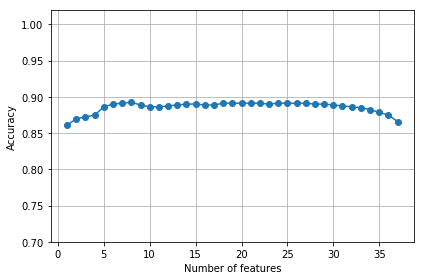

In [15]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [11]:
k2 = list(sbs.subsets_[-2])
print(df_bank.columns[k2])

Index(['pdays', 'education_primary'], dtype='object')


In [12]:
k3 = list(sbs.subsets_[-3])
print(df_bank.columns[k3])

Index(['pdays', 'job_admin.', 'education_primary'], dtype='object')


# Step3: Using features "duration" and "job_entrepreneur" to train data by ppn

In [306]:
X1 = df_bank.iloc[:,[7,14]]
y1 = df_bank.iloc[:,11]
X1.head()

,duration,job_entrepreneur
0,79,0
1,220,0
2,185,0
3,199,0
4,226,0


In [307]:
#splittings the data
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.3, random_state=1, stratify=y1)

In [308]:
#Standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X1_train)
X1_train_std = sc.transform(X1_train)
X1_test_std = sc.transform(X1_test)

In [309]:
# Training a perceptron via scikit-learn
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=40, eta0=0.1, random_state=1)
ppn.fit(X1_train_std, y1_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      max_iter=40, n_iter=None, n_jobs=1, penalty=None, random_state=1,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [310]:
#Defining a plot function for all data
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

In [311]:
#Checking accuracy
y1_pred = ppn.predict(X1_test_std)
print('Misclassified samples: %d' % (y1_test != y1_pred).sum())

from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y1_test, y1_pred))

Misclassified samples: 153
Accuracy: 0.89


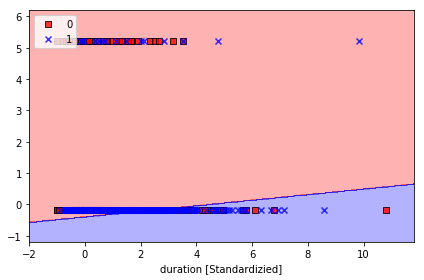

In [312]:
#Plotting the outcome
X1_combined_std = np.vstack((X1_train_std, X1_test_std))
y1_combined = np.hstack((y1_train, y1_test))

plot_decision_regions(X1_combined_std, y1_combined, 
                      classifier=ppn)
plt.xlabel('duration [Standardizied]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Step4: Using the features "age" and "duration" to train data by Logistic Regression

In [406]:
X2 = df_bank.iloc[:,[0,7]]
y2 = df_bank.iloc[:,11]
X2.head()

,age,duration
0,30,79
1,33,220
2,35,185
3,30,199
4,59,226


In [407]:
#splitting the data

from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.3, random_state=1, stratify=y2)

In [408]:
print('Labels counts in y2:', np.bincount(y2)) 
print('Labels counts in y2_train:', np.bincount(y2_train))
print('Labels counts in y2_test:', np.bincount(y2_test))

Labels counts in y2: [4000  521]
Labels counts in y2_train: [2799  365]
Labels counts in y2_test: [1201  156]


In [409]:
#standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X2_train)
X2_train_std = sc.transform(X2_train)
X2_test_std = sc.transform(X2_test)

In [410]:
#Logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X2_train_std, y2_train)


LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [411]:
#Checking the accuracy
y2_pred = lr.predict(X2_test_std)
print('Misclassified samples: %d' % (y2_test != y2_pred).sum())

from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y2_test, y2_pred))

Misclassified samples: 150
Accuracy: 0.89


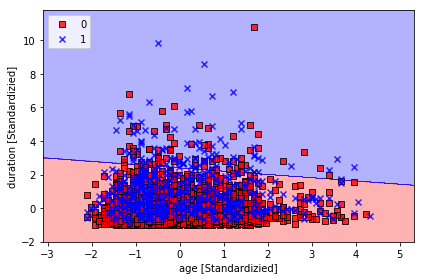

In [412]:
# Visualizing the outcome
X2_combined_std = np.vstack((X2_train_std, X2_test_std))
y2_combined = np.hstack((y2_train, y2_test))

plot_decision_regions(X2_combined_std, 
                      y2_combined,
                      classifier=lr)
plt.xlabel('age [Standardizied]')
plt.ylabel('duration [Standardizied]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Step5: Using the features "duration" and "balance" to train data by SVM

In [419]:
X3 = df_bank.iloc[:,[7,2]]
y3 = df_bank.iloc[:,11]
X3.head()

,duration,balance
0,79,1787
1,220,4789
2,185,1350
3,199,1476
4,226,0


In [420]:
#splitting the data

from sklearn.model_selection import train_test_split

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.3, random_state=1, stratify=y3)

In [421]:
#Standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X3_train)
X3_train_std = sc.transform(X3_train)
X3_test_std = sc.transform(X3_test)

In [422]:
#Using non-linear SVM model
from sklearn.svm import SVC
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X3_train_std, y3_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [423]:
#Checking accuracy
y3_pred = svm.predict(X3_test_std)
print('Misclassified samples: %d' % (y3_test != y3_pred).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y3_test, y3_pred)) 

Misclassified samples: 150
Accuracy: 0.89


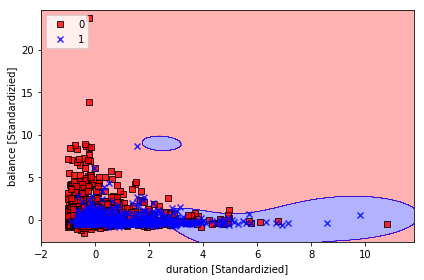

In [424]:
X3_combined_std = np.vstack((X3_train_std, X3_test_std))
y3_combined = np.hstack((y3_train, y3_test))

plot_decision_regions(X3_combined_std, y3_combined, 
                      classifier=svm)
plt.xlabel('duration [Standardizied]')
plt.ylabel('balance [Standardizied]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()